# Titanic Survival 

## Objective:
In this project, I attempt to analyze a popular dataset in Kaggale about [**Titanic**](https://www.kaggle.com/c/titanic/data). The dataset contains number of features about the passengers. Below are all features describing passengers. By further analyzing dataset, we attempt to find a model that might help us undarstand the different features contributed to the survival of some passengers more than others.

- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)  
- (Target variable) **Survived**: Outcome of survival (0 = No; 1 = Yes)  

### 1- importing all libraries needed for this analysis. 

In [34]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score, make_scorer, accuracy_score
%matplotlib inline

In [2]:
# Load the dataset
data = pd.read_csv('titanic_data.csv')
# Print the first few entries of the Titanic data
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.shape

(891, 12)

#### The dataset has all the columns described earlier above:

|columns|rows|
|-------|----|
|12|891|



### 2- Cleanining the dataset
#### 2.1- Removing outliers

First step in cleaning dataset is to remove any outliers. Outliers might affect in training the model later in this project and might effect predictions. By removing outliers, we reduce the risk of overfitting and the prediction model will generalize prediction result. We choose to remove any row with a numerical data that is beyound 1.5 standard deviation from the mean. 

In [4]:
# importing counter from collections library 
from collections import Counter

# a function to identify row index of an outlier
# and then fillter and remove rows
def find_outliers(df,n,features):
    
    outlier_idx = []
    
    for col in features:
        q1 = np.percentile(df[col],25) 
        q3 = np.percentile(df[col],75)
        iqr = q3-q1
        
        outlier_step = 1.5*iqr
        
        outlier_list_col = df[(df[col] < q1-outlier_step) | (df[col] > q3+outlier_step)].index
        outlier_idx.extend(outlier_list_col)
        
    outlier_idx = Counter(outlier_idx)
    multi_outliers = list(k for k,v in outlier_idx.items() if v > n)
    return multi_outliers

# boolean mask of rows with outliers
del_outliers = find_outliers(data,2,['Age','SibSp','Parch','Fare'])

In [5]:
# rows with outliers
data.loc[del_outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
# removing outlier rows from the dataset
data = data.drop(del_outliers, axis=0).reset_index(drop=True)
data.shape

(881, 12)

We started with **891** rows and after removing rows with outliers **10**,
we have left with **881** rows.

#### 2.2- Data exploration

In [7]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

**From above:**

|column|number of missing data|
|------|----------------------|
|Age|170|
|Cabin|680|
|Embarked|2|

It seems we have a lot of missing data for both Cabin and Age. Since missing values are not helpful in making a model to help us predict how likely a passenger will surviv. Hence, droping columns with missing data will not be first step. Instead, we will continue out exploration of the data to discover any relationship between feature that might help us in handling those missing values.

In [8]:
# exploring data types in dataset
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
data['Embarked'].value_counts()

S    634
C    168
Q     77
Name: Embarked, dtype: int64

The column **Embarked** has some unique values **S**, **C** and **Q**. Value **S** is the most common and because we have only 2 missing values, we will fill in value **S**. 

In [10]:
# fill in missing values with value s
data['Embarked'] = data['Embarked'].fillna('S')

In [11]:
# exploring values in 'Cabin'
data['Cabin'].value_counts().sort_values(ascending=False)

G6         4
B96 B98    4
C22 C26    3
D          3
F2         3
          ..
D7         1
D48        1
D47        1
C86        1
C106       1
Name: Cabin, Length: 147, dtype: int64

It seems there are no unique value in that column however we notice there are unique letters preceding number. We will attempt to extract letter to find how many unique letters are in each cabin value.

In [12]:
data['Cabin'].str[0].value_counts(dropna=False)

NaN    680
C       56
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: Cabin, dtype: int64

In [13]:
# summery statistics of dataset
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,881.000000,881.000000,881.000000,881,881,711.000000,881.000000,881.000000,881,881.000000,201,881
unique,NaN,NaN,NaN,881,2,NaN,NaN,NaN,680,NaN,147,3
top,NaN,NaN,NaN,"Vestrom, Miss. Hulda Amanda Adolfina",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,572,NaN,NaN,NaN,7,NaN,4,636
mean,446.713961,0.385925,2.307605,NaN,NaN,29.731603,0.455165,0.363224,NaN,31.121566,NaN,NaN
std,256.617021,0.487090,0.835055,NaN,NaN,14.547835,0.871571,0.791839,NaN,47.996249,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,226.000000,0.000000,2.000000,NaN,NaN,20.250000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,448.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.000000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.500000,NaN,NaN


In [14]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

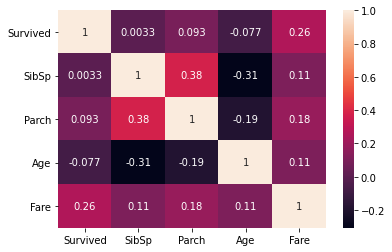

In [15]:
sns.heatmap(data[['Survived','SibSp','Parch','Age','Fare']].corr(),
           annot=True)

Looking on correlations between numerical columns in the dataset, there is no strong correlation exist between columns.
This is not helpful at the moment as it doesn't show possible ways to empute missing values in age column.

C:\Users\Asus 20\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


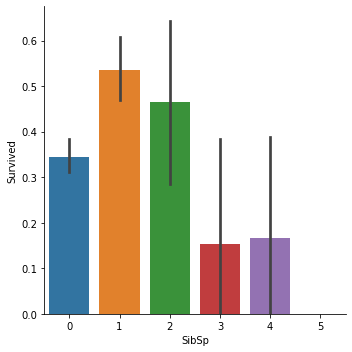

In [16]:
# SibSp
sns.factorplot(x='SibSp', y='Survived', data=data,kind='bar')

**Form the plot:**

- Passengars without or with  1 or 2 siblings and spouses  have a higher chance of surviving 
- Passengers with 3 or more siblings and spouses have less chance of surviving 
- Most likly to survive are passengers with one spous/sibling
- least likely passenger to survive, passengers with more than 3 spouses/siblings

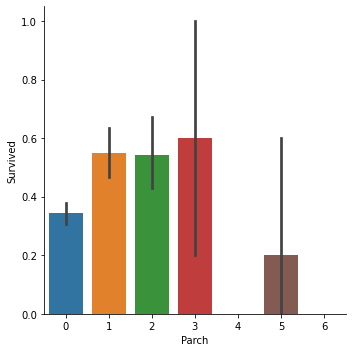

In [17]:
# Parch
sns.factorplot(x='Parch', y='Survived', data=data,kind='bar')

**From the plot:**
- Passengers with parents/children more likely to survive
- Passengers with 4 or more have the lowest survival score
- Highest survival score for passengers with 3 parents/children

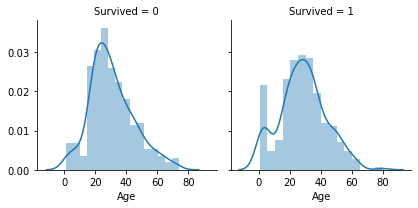

In [18]:
# Age 
sns.FacetGrid(data, col='Survived').map(sns.distplot,'Age')

**From the plot:**
- age group of (20-60) seem to make the most in both plots
- age groups (0-20) and (60-80) making the minority on both plots
- it seems there is another factor has influenced the similarity between plots

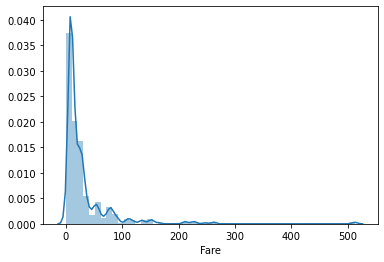

In [19]:
# Fare distribution
sns.distplot(data['Fare'])

Fare column is heavily right skewed and that will introduc baise to our model whilest training.
Hence, we will log transform Fare column to mirror nearly normal distribution.

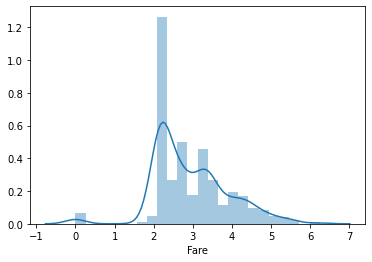

In [20]:
data['Fare'] = data['Fare'].map(lambda x: np.log(x+1))
sns.distplot(data['Fare'])

Text(0, 0.5, 'Survival')

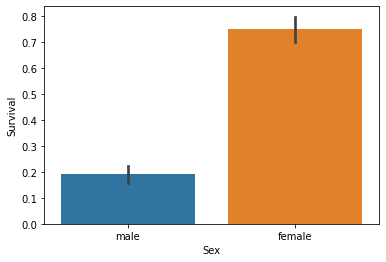

In [21]:
sns.barplot(x='Sex',y='Survived',data=data).set_ylabel('Survival')

In above plot, it is clear that gender has huge influance of survival as Female gender are more likely to survive than male. This might explain Age column distribution in earlier plot. 

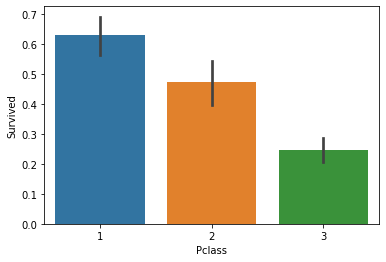

In [22]:
sns.barplot(x='Pclass', y='Survived',data=data)

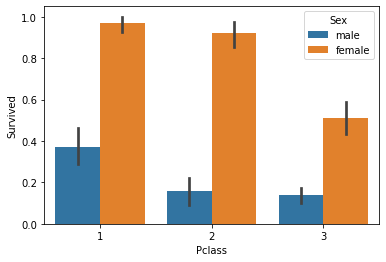

In [23]:
sns.barplot(x='Pclass',y='Survived',hue='Sex',data=data)

Across all ticket classes, female gender are more likely to survive than male. This might mean that male passengers with sbouses and parents choose to save female relative than themselves. 

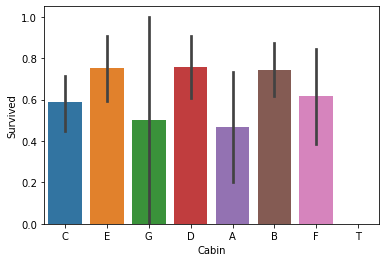

In [24]:
sns.barplot(x=data['Cabin'].str[0],y='Survived',data=data)

As we see from the plot above, survival score is distributed between different cabin classes which implies the importance of this column to be considered for further analysis. For the large number of missing values of this column, we wil use this information as another classe 'U' referring to unknown. 

In [25]:
data['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'U' for i in data['Cabin'])
data[data['Cabin']=='U']['Cabin'].value_counts()

U    680
Name: Cabin, dtype: int64

In [26]:
age_pv = data.pivot_table(values='Age',columns='Survived',
                          aggfunc=[np.mean,np.median],
                          dropna=False).T
age_pv

Age
       Survived           
mean   0         30.653664
       1         28.377326
median 0         28.000000
       1         28.000000

Further examining the distribution of age between survived and did't survive, the median value is the same at age 28. We will impute missing ages with the median. 

In [27]:
data['Age'].fillna(value=28,inplace=True)
data['Age'].isnull().sum()

0

In [28]:
# define variables(features, outcomes)
#Note: do not include Name column with features 
outcomes = data['Survived']

# Show the new dataset with 'Survived' removed
features = data.drop(['Survived', 'Name'],axis = 1)

In [29]:
#data exploration:
features.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,male,22.0,1,0,A/5 21171,2.110213,U,S
1,2,1,female,38.0,1,0,PC 17599,4.280593,C,C
2,3,3,female,26.0,0,0,STON/O2. 3101282,2.188856,U,S
3,4,1,female,35.0,1,0,113803,3.990834,C,S
4,5,3,male,35.0,0,0,373450,2.202765,U,S


In above step, we splited dataset to:
- Target variable to be predicted (survived)
- Considered features (all columns except name)

## Preprocessing the data


In [30]:
from sklearn.preprocessing import StandardScaler
#transformation: Perform feature scaling on the data
# first: define the standardization scaling object using StandardScaler().
standard_scaler = StandardScaler()
# second: apply the scaler to the numerical columns on the data:
numaric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
features[numaric_features] = standard_scaler.fit_transform(features[numaric_features])
features.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.829632,male,-0.565653,0.625474,-0.458969,A/5 21171,-0.872244,U,S
1,2,-1.566780,female,0.657799,0.625474,-0.458969,PC 17599,1.400796,C,C
2,3,0.829632,female,-0.259790,-0.522532,-0.458969,STON/O2. 3101282,-0.789882,U,S
3,4,-1.566780,female,0.428402,0.625474,-0.458969,113803,1.097331,C,S
4,5,0.829632,male,0.428402,-0.522532,-0.458969,373450,-0.775315,U,S


Scaling numerical columns is a necessary step so that different scale columns won't effect training the model and introduce wrong inferance. 

In [31]:
#dummies variables: convert catogrical columns to numerical
## perform one-hot encoding on categorical columns Using pandas.get_dummies()
features = pd.get_dummies(features)

In [32]:
features.shape

(881, 700)

Most models can't deal with categorical values and converting those values to numerical values is a neseccary step before starting the training part. Above, we one-hot encoded categorical values to have values of 0 and one. This step increased number of columns to 700. 

In [35]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html
selector = SelectPercentile(f_classif, percentile=60)
selector.fit(features, outcomes)
features = selector.transform(features)
features.shape

(881, 420)

Since 700 columns is a large number of columns, we used ``SelectPercentile`` methode from sklearn library to select only important columns for training our model. 

## Training the model

Now we're ready to train a model in sklearn. First, let's split the data into training and testing sets. Then we'll train the model on the training set.

In [37]:
#split the data to two sets. training set and testing set:
x_train,x_test,y_train,y_test = train_test_split(features,outcomes,test_size=0.2,random_state=0)

In [54]:
# Define the classifier model as Random Forest Classifier
model = DecisionTreeClassifier()

#fit the model to the data
model.fit(x_train,y_train)

DecisionTreeClassifier()

## Testing the model
Now, let's see how our model does, let's calculate the accuracy over both the training and the testing set.

In [56]:
# Making predictions on scaling data
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
# accuracy_score calculation
train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)

print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.9971590909090909
The test accuracy is 0.864406779661017


# Improving the model

Ok, high training accuracy and a lower testing accuracy. We might be overfitting a bit.

Next we will specify some parameters in order to improve the testing accuracy, such as:
- `max_depth` The maximum number of levels in the tree.
- `min_samples_leaf` The minimum number of samples allowed in a leaf.
- `min_samples_split` The minimum number of samples required to split an internal node.

In [59]:
#grid search
#import gridsearch

#define the classifier model by random forest
clf = DecisionTreeClassifier(random_state=0)

#define the parameters:
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'max_depth': [5, 6, 7,8, 9, 10], 'min_samples_leaf': [2, 3, 4, 5, 6], 'min_samples_split': [5, 6, 7, 8, 9, 10]}

#define the score method using make_scorer()
scorer = make_scorer(accuracy_score)

#define gridsearchcv function with cv=3 (so cross validation=3)
grid_obj = GridSearchCV(clf,parameters,cv=3)
#fit/ train the function/ object
grid_fit = grid_obj.fit(x_train,y_train)
#get the best estimtor model
best_clf = grid_fit.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=9, min_samples_leaf=3, min_samples_split=8,
                       random_state=0)

In [60]:
# Make predictions using the new model.
y_train_pred = best_clf.predict(x_train)
y_test_pred = best_clf.predict(x_test)

# Calculating accuracies
train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)

print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.8849431818181818
The test accuracy is 0.8361581920903954


It might not seem that we made any improvments since:
- Training accuracy 
  - before 99%
  - now 88%
- Testing accuracy 
  - before 86%
  - now 83% 
  
But we improved the overfitting issue we had earlier when the model has no generalization and seemed to be memorizing rather than infering. after we changed some of defualt parameters of the model and introduced cross validation, the model was able to generalize well as there was small gap between training data accuracy sore ``88%`` and testing accuracy score ``83%``.